## Import important stuff

In [467]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn import linear_model, svm, tree
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from Backend.Evaluation.metrics import compute_evaluation_metrics
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import xgboost as xgb


### def create tuple

#### delete districts, transform variant, delet others

In [468]:
 # 1) separate beta, delete districts, transform variant
df = pd.read_csv("all_matrix_data_v2.csv")
df

,Unnamed: 0,week,policy_index,variant,mobility,temperature,wind,infections,beta,beta_t_minus_1,district
0,0,2,62.500000,Other,-41.714286,4.885714,24.057143,4.897959,2.621485e-01,0.405904,Landkreis St. Wendel
1,1,3,63.778571,Other,-36.000000,5.971429,14.714286,3.326531,1.550497e-01,0.269774,Landkreis St. Wendel
2,2,4,65.180000,Other,-31.142857,16.085714,11.900000,1.122449,3.379712e-18,0.278678,Landkreis St. Wendel
3,3,5,65.180000,Other,-31.857143,12.357143,12.542857,0.500000,1.574978e-02,0.002448,Landkreis St. Wendel
4,4,6,65.180000,Other,-23.571429,13.685714,19.585714,0.704082,5.966302e-01,0.014601,Landkreis St. Wendel
...,...,...,...,...,...,...,...,...,...,...,...
37195,88,90,81.761429,B.1.617.2,1.857143,2.185714,14.614286,165.051020,5.811076e-01,0.612582,Wartburgkreis
37196,89,91,83.930000,B.1.617.2,6.000000,0.857143,9.814286,145.214286,4.988738e-01,0.586679,Wartburgkreis
37197,90,92,83.930000,B.1.617.2,6.571429,5.028571,7.842857,105.612245,3.810974e-01,0.542123,Wartburgkreis
37198,91,93,83.930000,B.1.617.2,-2.714286,-1.842857,10.771429,83.377551,4.671758e-01,0.425633,Wartburgkreis


In [469]:
#transform variant
df_1 = pd.get_dummies(df['variant'])
df_1

,0,B.1.1.7,B.1.617.2,Other
0,0,0,0,1
1,0,0,0,1
2,0,0,0,1
3,0,0,0,1
4,0,0,0,1
...,...,...,...,...
37195,0,0,1,0
37196,0,0,1,0
37197,0,0,1,0
37198,0,0,1,0


In [470]:
df_2 = df.drop(columns='variant')
df = pd.concat([df_1, df_2], axis=1)
#delete districts
df = df.drop(columns='district')
df

,0,B.1.1.7,B.1.617.2,Other,Unnamed: 0,week,policy_index,mobility,temperature,wind,infections,beta,beta_t_minus_1
0,0,0,0,1,0,2,62.500000,-41.714286,4.885714,24.057143,4.897959,2.621485e-01,0.405904
1,0,0,0,1,1,3,63.778571,-36.000000,5.971429,14.714286,3.326531,1.550497e-01,0.269774
2,0,0,0,1,2,4,65.180000,-31.142857,16.085714,11.900000,1.122449,3.379712e-18,0.278678
3,0,0,0,1,3,5,65.180000,-31.857143,12.357143,12.542857,0.500000,1.574978e-02,0.002448
4,0,0,0,1,4,6,65.180000,-23.571429,13.685714,19.585714,0.704082,5.966302e-01,0.014601
...,...,...,...,...,...,...,...,...,...,...,...,...,...
37195,0,0,1,0,88,90,81.761429,1.857143,2.185714,14.614286,165.051020,5.811076e-01,0.612582
37196,0,0,1,0,89,91,83.930000,6.000000,0.857143,9.814286,145.214286,4.988738e-01,0.586679
37197,0,0,1,0,90,92,83.930000,6.571429,5.028571,7.842857,105.612245,3.810974e-01,0.542123
37198,0,0,1,0,91,93,83.930000,-2.714286,-1.842857,10.771429,83.377551,4.671758e-01,0.425633


In [471]:
# Drop "other" variant column to prevent dummy variable trap:
df = df.drop(columns='Other', axis=1)
# Drop zero column:
df = df.drop(columns='0', axis=1)

#### delete infections = 0, fill empty wind and temeprature rows

In [472]:
df.drop(df[df['infections'] == 0.0].index, inplace=True)
df.reset_index(inplace=True, drop=True)

In [473]:
df_v4 = df.copy()

In [474]:
df_v4['temperature'] = df.groupby("week").transform(lambda x: x.fillna(x.mean()))['temperature']
df_v4['wind'] = df.groupby("week").transform(lambda x: x.fillna(x.mean()))['wind']

In [475]:
df = df_v4
df

,B.1.1.7,B.1.617.2,Unnamed: 0,week,policy_index,mobility,temperature,wind,infections,beta,beta_t_minus_1
0,0,0,0,2,62.500000,-41.714286,4.885714,24.057143,4.897959,2.621485e-01,0.405904
1,0,0,1,3,63.778571,-36.000000,5.971429,14.714286,3.326531,1.550497e-01,0.269774
2,0,0,2,4,65.180000,-31.142857,16.085714,11.900000,1.122449,3.379712e-18,0.278678
3,0,0,3,5,65.180000,-31.857143,12.357143,12.542857,0.500000,1.574978e-02,0.002448
4,0,0,4,6,65.180000,-23.571429,13.685714,19.585714,0.704082,5.966302e-01,0.014601
...,...,...,...,...,...,...,...,...,...,...,...
36771,0,1,88,90,81.761429,1.857143,2.185714,14.614286,165.051020,5.811076e-01,0.612582
36772,0,1,89,91,83.930000,6.000000,0.857143,9.814286,145.214286,4.988738e-01,0.586679
36773,0,1,90,92,83.930000,6.571429,5.028571,7.842857,105.612245,3.810974e-01,0.542123
36774,0,1,91,93,83.930000,-2.714286,-1.842857,10.771429,83.377551,4.671758e-01,0.425633


#### delete small betas

In [476]:
df.drop(df[df['beta'] <= 0.025].index, inplace=True)
df.reset_index(inplace=True, drop=True)

#### create beta, delete beta from dataframe

#### Standadizing

In [477]:
#save the given model
def save_standardizing_model(model):
    filename = 'standardizing_model.sav'
    pickle.dump(model, open(filename, 'wb'))

In [478]:
# Standardize:
scaler_obj = StandardScaler()

# Split explanatory columns from beta:
explanatory_cols = df.drop(columns=['beta_t_minus_1', 'beta', 'week'], axis=1)
beta_cols = df[['beta_t_minus_1', 'beta', 'week']]

# Apply scaling:
scaled_explanatory_cols = pd.DataFrame(scaler_obj.fit_transform(explanatory_cols), index=explanatory_cols.index, columns=explanatory_cols.columns)

# Merge both together again:
df = pd.concat([scaled_explanatory_cols, beta_cols], axis=1)
save_standardizing_model(scaler_obj)
df

,B.1.1.7,B.1.617.2,Unnamed: 0,policy_index,mobility,temperature,wind,infections,beta_t_minus_1,beta,week
0,-0.587296,-0.643395,-1.775476,-0.469712,-2.550286,-0.828519,3.695803,-0.363677,0.405904,0.262149,2
1,-0.587296,-0.643395,-1.737497,-0.291658,-2.183685,-0.666092,1.053923,-0.386043,0.269774,0.155050,3
2,-0.587296,-0.643395,-1.623557,-0.096495,-1.386327,0.487997,2.431417,-0.423368,0.014601,0.596630,6
3,-0.587296,-0.643395,-1.585577,0.483224,-1.633783,0.024224,1.183189,-0.424530,0.416047,0.248171,7
4,-0.587296,-0.643395,-1.509618,-0.641201,-0.671454,-0.125380,1.284178,-0.431646,0.005292,0.026824,9
...,...,...,...,...,...,...,...,...,...,...,...
34866,-0.587296,1.554256,1.566749,2.212635,0.245049,-1.232451,1.025646,1.915740,0.612582,0.581108,90
34867,-0.587296,1.554256,1.604729,2.514630,0.510835,-1.431210,-0.331651,1.633409,0.586679,0.498874,91
34868,-0.587296,1.554256,1.642709,2.514630,0.547495,-0.807147,-0.889112,1.069763,0.542123,0.381097,92
34869,-0.587296,1.554256,1.680689,2.514630,-0.048232,-1.835142,-0.060999,0.753303,0.425633,0.467176,93


#### split into test data

In [479]:
max_week = df['week'].max()
X_df = df.loc[df['week'] < max_week-5]
X_test = df.loc[df['week'] > max_week-6]
beta_df = pd.DataFrame(X_df['beta'])
y_test = pd.DataFrame(X_test['beta'])
X_df.reset_index(inplace=True)
X_df = X_df.drop(columns='index')
X_test.reset_index(inplace=True)
X_test = X_test.drop(columns='index')
beta_df.reset_index(inplace=True)
beta_df = beta_df.drop(columns='index')
y_test.reset_index(inplace=True)
y_test = y_test.drop(columns='index')
beta_np = beta_df.to_numpy()


#### delete beta, create beta

In [480]:
#delete beta
X_df = X_df.drop(columns='beta')
X_test = X_test.drop(columns='beta')
X_test


,B.1.1.7,B.1.617.2,Unnamed: 0,policy_index,mobility,temperature,wind,infections,beta_t_minus_1,week
0,-0.587296,1.554256,1.528769,1.194047,-0.112387,-1.441896,0.395472,0.098306,0.620975,89
1,-0.587296,1.554256,1.566749,2.212635,-0.084892,-1.405564,1.651780,0.004341,0.601931,90
2,-0.587296,1.554256,1.604729,2.514630,0.061748,-1.473955,0.589372,-0.151493,0.442100,91
3,-0.587296,1.554256,1.642709,2.514630,0.345864,-0.935379,-0.828518,-0.153091,0.255667,92
4,-0.587296,1.554256,1.680689,2.514630,0.080078,-1.461131,-0.044841,0.169760,0.318667,93
...,...,...,...,...,...,...,...,...,...,...
2225,-0.587296,1.554256,1.566749,2.212635,0.245049,-1.232451,1.025646,1.915740,0.612582,90
2226,-0.587296,1.554256,1.604729,2.514630,0.510835,-1.431210,-0.331651,1.633409,0.586679,91
2227,-0.587296,1.554256,1.642709,2.514630,0.547495,-0.807147,-0.889112,1.069763,0.542123,92
2228,-0.587296,1.554256,1.680689,2.514630,-0.048232,-1.835142,-0.060999,0.753303,0.425633,93


#### delete week and unnamed columns

In [481]:
X_df = X_df.drop(columns='week')
X_df = X_df.loc[:, ~X_df.columns.str.contains('^Unnamed')]
X_test = X_test.drop(columns='week')
X_test = X_test.loc[:, ~X_test.columns.str.contains('^Unnamed')]
X_df

,B.1.1.7,B.1.617.2,policy_index,mobility,temperature,wind,infections,beta_t_minus_1
0,-0.587296,-0.643395,-0.469712,-2.550286,-0.828519,3.695803,-0.363677,0.405904
1,-0.587296,-0.643395,-0.291658,-2.183685,-0.666092,1.053923,-0.386043,0.269774
2,-0.587296,-0.643395,-0.096495,-1.386327,0.487997,2.431417,-0.423368,0.014601
3,-0.587296,-0.643395,0.483224,-1.633783,0.024224,1.183189,-0.424530,0.416047
4,-0.587296,-0.643395,-0.641201,-0.671454,-0.125380,1.284178,-0.431646,0.005292
...,...,...,...,...,...,...,...,...
32636,-0.587296,1.554256,-1.287169,1.033242,-0.345512,1.316495,0.551575,0.708111
32637,-0.587296,1.554256,-1.144527,0.446680,-0.270710,0.940815,0.885754,0.754101
32638,-0.587296,1.554256,-1.090812,0.263379,-0.495116,0.052109,1.287612,0.704473
32639,-0.587296,1.554256,-0.972441,0.465010,-1.001633,-0.723489,1.612786,0.802756


#### Split into validation and training data

In [482]:
X_train, X_val, y_train, y_val = train_test_split(X_df, beta_df, shuffle=True, train_size=0.75, random_state=1)

### run all models to find best one

#### train and run the models

In [483]:
def run_train_val(X_train, y_train, X_val, y_val, modeltype):
    model = ml_training(X_train, y_train, modeltype)
    return(ml_val(X_val, y_val, model)), model


#### ML training

In [484]:
def ml_training(x, y, model):
    y = y.to_numpy()
    y = y.ravel()
    if model == "linear_regression":
        reg = linear_model.LinearRegression()
    elif model == "lasso":
        reg = linear_model.Lasso(alpha=0.1)
    elif model == "support_vector_machine":
        reg = svm.SVR()
    elif model == "linear_regression_tree":
        reg = tree.DecisionTreeRegressor()
    elif model == "ensemble_method_adaboost":
        reg = AdaBoostRegressor(random_state=0, n_estimators=100)
        reg.fit(x, y)
        return reg
    elif model == "neural_network":
        reg = MLPRegressor(random_state=1, max_iter=500).fit(x, y)
        return reg
    elif model == "random_forest_regressor":
        reg = RandomForestRegressor(n_estimators=10, random_state=0, max_depth=2)
        reg = reg.fit(x, y)
        return reg
    elif model == "XG_boost":
        xgb_model = xgb.XGBRegressor(verbosity=0)
        xgb_model.name = 'XGBoostRegressor'
        reg = xgb_model.fit(x, y)
        return reg
    reg.fit(x, y)
    return reg

#### ML validation

In [485]:
#validate the fitted model
def ml_val(X_val, y_val, model):
    pred = model.predict(X_val)
    scores = compute_evaluation_metrics(y_val,pred)
    return(scores["rmse"])

In [486]:
#save the given model
def save_model(model):
    filename = 'finalized_model.sav'
    pickle.dump(model, open(filename, 'wb'))

In [487]:
#load a previous saved model
def load_model():
    # load the model from disk
    filename = 'finalized_model.sav'
    loaded_model = pickle.load(open(filename, 'rb'))
    loaded_model
    return loaded_model

In [488]:
#test the fitted model: coompare pred and beta t-1
def ml_testing_beta(X_test, y_test):
    beta_t_1 = X_test['beta_t_minus_1']
    scores_beta = compute_evaluation_metrics(y_val=y_test, y_pred=beta_t_1)
    return scores_beta["rmse"]

In [489]:
type(y_train), type(y_val), y_train

(pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame,
            beta
 800    0.477804
 13617  0.292202
 21098  0.957946
 6890   0.708491
 3368   0.063154
 ...         ...
 32511  0.263056
 5192   0.695632
 12172  0.786655
 235    0.981799
 29733  0.225051
 
 [24480 rows x 1 columns])

In [490]:
#run all model types to find best model
rmse = []
min = 100000
metrics =["linear_regression", "lasso", "support_vector_machine", "linear_regression_tree", "ensemble_method_adaboost", "neural_network", "random_forest_regressor", "XG_boost"]
for i in range(len(metrics)):
    rmse.append(run_train_val(X_train, y_train, X_val, y_val, metrics[i]))
for i in range(len(rmse)):
    if rmse[i][0] < min:
        min = rmse[i][0]
        best_model = rmse[i][1]


### Store rmse results


In [491]:
save_model(best_model)
df = pd.DataFrame(rmse)
beta_rmse = []
beta_rmse.append((ml_testing_beta(X_val, y_val), 'beta_t_minus_1'))
df_1 = df.append(beta_rmse)
df_1.columns = ['RMSE', 'Model']
#df_1.to_csv('rmse.csv')
len(X_test)

2230

In [492]:
metrics.append('beta_t_minus_1')
df_2 = pd.DataFrame(metrics)
df_1.insert(loc=2, column='Model_Name', value=metrics, allow_duplicates=True)
df_1

,RMSE,Model,Model_Name
0,2.081140,LinearRegression(),linear_regression
1,2.084417,Lasso(alpha=0.1),lasso
2,2.125974,SVR(),support_vector_machine
3,2.468398,DecisionTreeRegressor(),linear_regression_tree
4,2.116579,"(DecisionTreeRegressor(max_depth=3, random_sta...",ensemble_method_adaboost
5,2.102572,"MLPRegressor(max_iter=500, random_state=1)",neural_network
6,2.113309,"(DecisionTreeRegressor(max_depth=2, max_featur...",random_forest_regressor
7,2.200953,"XGBRegressor(base_score=0.5, booster='gbtree',...",XG_boost
0,2.092526,beta_t_minus_1,beta_t_minus_1


### Plot rmse results

#### plot all rmse

LinearRegression()

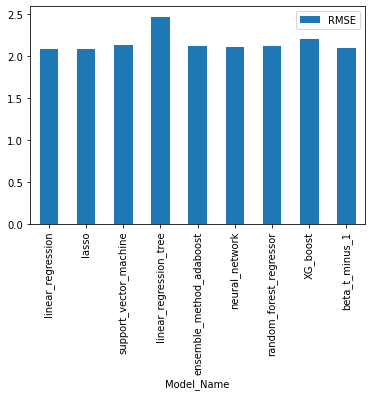

In [493]:
df_1.plot(x ='Model_Name', y='RMSE', kind = 'bar')
#plt.bar(df.Model, df.RMSE)
best_model

#### plot bets model, beta, beta t-1

In [494]:
pred_test = pd.DataFrame(best_model.predict(X_test))
beta_t_minus_1_test = pd.DataFrame(X_test['beta_t_minus_1'])
beta_t_minus_1_test.reset_index(inplace=True)
beta_t_minus_1_test = beta_t_minus_1_test.drop(columns='index')
y_test_df = pd.DataFrame(y_test)
y_test_df.reset_index(inplace=True)
y_test_df = y_test_df.drop(columns='index')
pred_test, beta_t_minus_1_test, y_test_df


(             0
 0     0.705668
 1     0.610905
 2     0.476018
 3     0.353359
 4     0.378069
 ...        ...
 2225  0.556816
 2226  0.517266
 2227  0.514233
 2228  0.425830
 2229  0.452696
 
 [2230 rows x 1 columns],
       beta_t_minus_1
 0           0.620975
 1           0.601931
 2           0.442100
 3           0.255667
 4           0.318667
 ...              ...
 2225        0.612582
 2226        0.586679
 2227        0.542123
 2228        0.425633
 2229        0.421383
 
 [2230 rows x 1 columns],
           beta
 0     0.524390
 1     0.359136
 2     0.257870
 3     0.605691
 4     1.135778
 ...        ...
 2225  0.581108
 2226  0.498874
 2227  0.381097
 2228  0.467176
 2229  0.498852
 
 [2230 rows x 1 columns])